# Process ISCCP files

__I need to fix the time format and interpolate to the CAM 1deg grid__

### Add paths to run locally or off Cheyenne or Casper 
(what is the difference between these two again?)

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from interp_functions import *

In [3]:
# In the CAM output, the ISCCP total is named "CLDTOT_ISCCP"

### Load CAM data for interpolation

In [4]:
case_dir = '/glade/scratch/jonahshaw/archive/Kay_COSP_2012/'

cam4metric = Cloud_Metric(case_dir)
cam4metric.add_case('cam4_1deg_release_amip',label='CAM4')

Loading GOCCP data...done.
Loading CALIOP SLFs...Could not load cloudtop CALIOP slfs from caliop_olimpia/ct_slf_olimpia/cloudtop_slfs.nc
Loading CERES-EBAF fluxes...done.
Loading ISCCP cloud total...Processed timeseries directory found for cam4_1deg_release_amip. Will load data as required.
cam4_1deg_release_amip load successfully.


### Plot to trigger variable loading

Could not find variable in GOCCP or CERES-EBAF datasets.


SystemExit: 

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


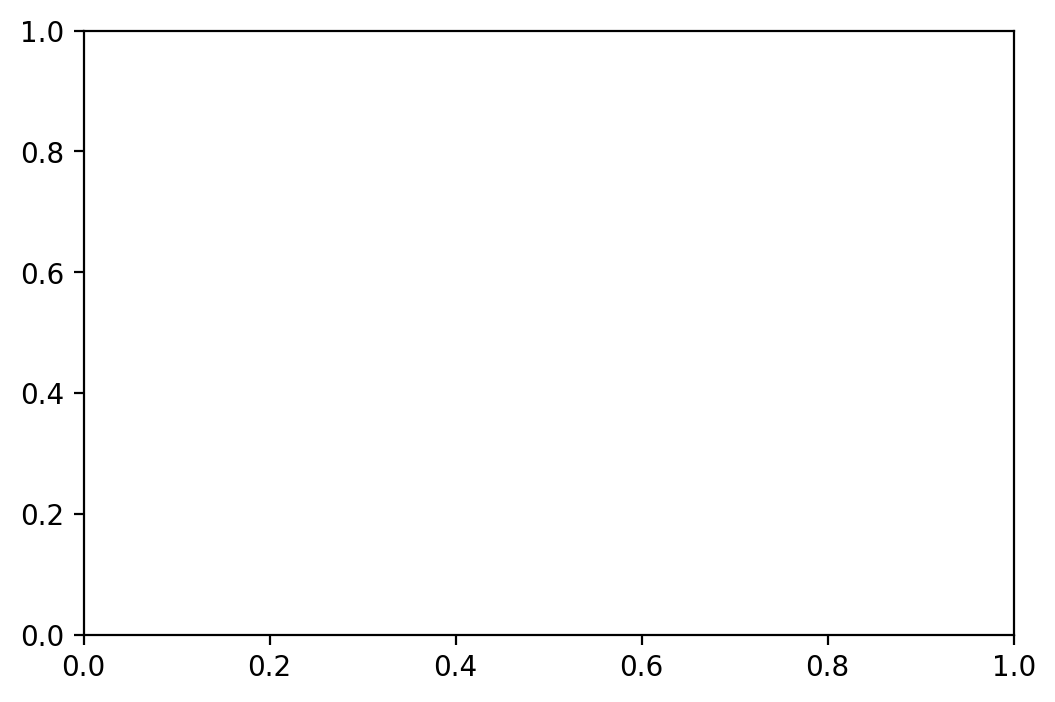

In [5]:
cam4metric.plot1D('CLDTOT_ISCCP');

____

In [6]:
cam4da = cam4metric.get_case('cam4_1deg_release_amip').case_da

### Load ISCCP data and fix the time format

In [7]:
ls /glade/work/jenkay/obs/COSP/ISCCP/

albisccp_198307-200806.nc             ctpisccp_198307-200806.nc
albisccp_unweighted_198307-200806.nc  ctpisccp_unweighted_198307-200806.nc
clisccp_198307-200806.nc              cttisccp_198307-200806.nc
cltisccp_198307-200806.nc             cttisccp_unweighted_198307-200806.nc


In [3]:
isccp_clt = xr.open_dataset('/glade/work/jenkay/obs/COSP/ISCCP/cltisccp_198307-200806.nc',decode_times=False)

isccp_clt['time'].attrs['units'] = isccp_clt['time'].attrs['units'] + '-01' # a little hacky

isccp_clt['time'].attrs['calendar'] = '360_day'

isccp_clt2 = xr.decode_cf(isccp_clt)

## Interpolate to the CAM grid

In [7]:
isccp_interpolated,_ = interp_like2D(isccp_clt2,cam4da['CLDTOT_ISCCP'])

### Copy over dataset-wide attributes

In [9]:
attrs = isccp_clt.attrs
# print(attrs['Comments'])

datestamp = datetime.today().strftime("%Y/%m/%d")
attrs['Comments'] = attrs['Comments'] + '. Interpolated to 1.25x1 deg CESM grid and time format updated by Jonah Shaw on %s.' % datestamp
# print(attrs['Comments'])
isccp_interpolated = isccp_interpolated.assign_attrs(isccp_clt.attrs)

In [22]:
isccp_interpolated.attrs

{'regrid_method': 'bilinear',
 'Description': 'Simulator-oriented ISCCP total cloud fraction. Monthly data',
 'Conventions': 'CF-1.4',
 'Coverage': '198307-200806',
 'References': 'http://eosweb.larc.nasa.gov/PRODOCS/isccp/table_isccp.html',
 'Comments': 'The equal-area monthly mean data are generated from the ISCCP-D1 data by Dr. Robert Pincus, University of Colorado. Interpolated to 1.25x1 deg CESM grid and time format updated by Jonah Shaw on 2021/02/24.',
 'Institution': 'Lawrence Livermore National Lab',
 'Contact': 'Yuying Zhang <zhang24@llnl.gov>',
 'CreationDate': '20101008'}

### Write python-ready file to Jonah obs directory

In [23]:
save_dir = '/glade/work/jonahshaw/obs/ISCCP/'

In [24]:
filename = 'cltisccp_198307-200806.nc'

In [25]:
dest_path = "%s/%s" % (save_dir,filename)
dest_path

'/glade/work/jonahshaw/obs/ISCCP//cltisccp_198307-200806.nc'

In [28]:
isccp_interpolated.to_netcdf(dest_path)

# Streamline with loops

In [8]:
og_dir = '/glade/work/jenkay/obs/COSP/ISCCP/'
save_dir = '/glade/work/jonahshaw/obs/ISCCP/'

In [18]:
files = os.listdir('/glade/work/jenkay/obs/COSP/ISCCP/')

for i in files:
    filepath = "%s/%s" % (og_dir,i)
    outpath = "%s/%s" % (save_dir,i)
    print(filepath)
    
    ds = xr.open_dataset(filepath,decode_times=False)

    ds['time'].attrs['units'] = ds['time'].attrs['units'] + '-01' # a little hacky

    ds['time'].attrs['calendar'] = '360_day'

    ds2 = xr.decode_cf(ds)
    
    ds_interpd,_ = interp_like2D(ds2,cam4da['CLDTOT_ISCCP'])  
    
    # Copy attributes over
    attrs = ds.attrs
    datestamp = datetime.today().strftime("%Y/%m/%d")
    attrs['Comments'] = attrs['Comments'] + '. Interpolated to 1.25x1 deg CESM grid and time format updated by Jonah Shaw on %s.' % datestamp
    # print(attrs['Comments'])
    ds_interpd = ds_interpd.assign_attrs(attrs)
    
    ds_interpd.to_netcdf(outpath)
    
#     break

/glade/work/jenkay/obs/COSP/ISCCP//ctpisccp_198307-200806.nc
/glade/work/jenkay/obs/COSP/ISCCP//cttisccp_unweighted_198307-200806.nc
/glade/work/jenkay/obs/COSP/ISCCP//cttisccp_198307-200806.nc
/glade/work/jenkay/obs/COSP/ISCCP//albisccp_unweighted_198307-200806.nc
/glade/work/jenkay/obs/COSP/ISCCP//albisccp_198307-200806.nc
/glade/work/jenkay/obs/COSP/ISCCP//ctpisccp_unweighted_198307-200806.nc
/glade/work/jenkay/obs/COSP/ISCCP//clisccp_198307-200806.nc
/glade/work/jenkay/obs/COSP/ISCCP//cltisccp_198307-200806.nc


# Old Work

### Find the files

In [38]:
testy = isccp_interpolated.groupby('time.month').mean('time')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [43]:
out = testy.mean('month')

In [48]:
isccpobs = out['cltisccp'] #.plot()

In [49]:
cam4isccp = cam4da['CLDTOT_ISCCP'].groupby('time.month').mean('time').mean('month')#.plot()

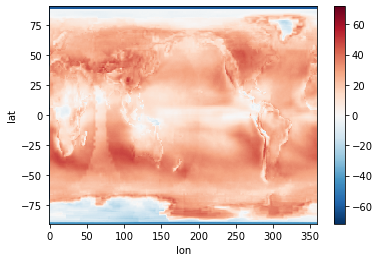

In [50]:
(isccpobs - cam4isccp).plot()

In [7]:
os.chdir('/glade/work/jenkay/obs/COSP')

In [8]:
ls

CALIPSO/  CLOUDSAT/  MISR/   readme_obs4COSP.txt
CERES/    ISCCP/     MODIS/  readme_obs4COSP.txt~


In [19]:
isccp_clt = xr.open_dataset('ISCCP/cltisccp_198307-200806.nc',decode_times=False)

isccp_clt['time'].attrs['units'] = isccp_clt['time'].attrs['units'] + '-01' # a little hacky

isccp_clt['time'].attrs['calendar'] = '360_day'

isccp_clt2 = xr.decode_cf(isccp_clt)

In [21]:
isccp_clt2

<xarray.Dataset>
Dimensions:    (latitude: 72, longitude: 144, time: 300)
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 -178.75 -176.25 -173.75 ... 176.25 178.75
  * time       (time) object 1983-07-01 00:00:00 ... 2008-06-01 00:00:00
Data variables:
    cltisccp   (time, latitude, longitude) float32 ...
Attributes:
    Description:   Simulator-oriented ISCCP total cloud fraction. Monthly data
    Conventions:   CF-1.4
    Coverage:      198307-200806
    References:    http://eosweb.larc.nasa.gov/PRODOCS/isccp/table_isccp.html
    Comments:      The equal-area monthly mean data are generated from the IS...
    Institution:   Lawrence Livermore National Lab
    Contact:       Yuying Zhang <zhang24@llnl.gov>
    CreationDate:  20101008

In [15]:
isccp_clt['time'].attrs['calendar']

'360_day'

### Time fix:

https://rabernat.github.io/research_computing_2018/xarray-tips-and-tricks.html

In [55]:
def fix_calendar(ds, timevar='T'):
    if ds[timevar].attrs['calendar'] == '360':
        ds[timevar].attrs['calendar'] = '360_day'
    return ds

isccp_clt = fix_calendar(isccp_clt,timevar='time')
isccp_clt = xr.decode_cf(isccp_clt)
isccp_clt

ValueError: unable to decode time units 'months since 1983-06' with "calendar '360_day'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [66]:
cftime.num2date(0, 'months since 1960-01-01', '360_day')

cftime.Datetime360Day(1960, 1, 1, 0, 0, 0, 0)

In [68]:
cftime.num2date(0, 'months since 1983-06', '360_day')

cftime.Datetime360Day(1983, 6, 1, 0, 0, 0, 0)

In [60]:
isccp_clt.attrs

{'Description': 'Simulator-oriented ISCCP total cloud fraction. Monthly data',
 'Conventions': 'CF-1.4',
 'Coverage': '198307-200806',
 'References': 'http://eosweb.larc.nasa.gov/PRODOCS/isccp/table_isccp.html',
 'Comments': 'The equal-area monthly mean data are generated from the ISCCP-D1 data by Dr. Robert Pincus, University of Colorado',
 'Institution': 'Lawrence Livermore National Lab',
 'Contact': 'Yuying Zhang <zhang24@llnl.gov>',
 'CreationDate': '20101008',
 'calendar': '360_day'}

In [59]:
isccp_clt = isccp_clt.assign_attrs({'calendar': '360_day'})

In [63]:
xr.decode_cf(isccp_clt,decode_times='360')

ValueError: unable to decode time units 'months since 1983-06' with "calendar '360_day'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [76]:
isccp_clt['time'].attrs['calendar'] = '360_day'
xr.decode_cf(isccp_clt)

<xarray.Dataset>
Dimensions:    (latitude: 72, longitude: 144, time: 300)
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 -178.75 -176.25 -173.75 ... 176.25 178.75
  * time       (time) object 1983-07-01 00:00:00 ... 2008-06-01 00:00:00
Data variables:
    cltisccp   (time, latitude, longitude) float32 ...
Attributes:
    Description:   Simulator-oriented ISCCP total cloud fraction. Monthly data
    Conventions:   CF-1.4
    Coverage:      198307-200806
    References:    http://eosweb.larc.nasa.gov/PRODOCS/isccp/table_isccp.html
    Comments:      The equal-area monthly mean data are generated from the IS...
    Institution:   Lawrence Livermore National Lab
    Contact:       Yuying Zhang <zhang24@llnl.gov>
    CreationDate:  20101008
    calendar:      360_day

In [73]:
isccp_clt['time'].attrs['units'] = 'months since 1983-06-01'

In [74]:
isccp_clt['time'].attrs['units']

'months since 1983-06-01'

In [75]:
xr.decode_cf(isccp_clt)

ValueError: unable to decode time units 'months since 1983-06-01' with "calendar '360'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [44]:
isccp_clt = xr.open_dataset('ISCCP/cltisccp_198307-200806.nc',decode_times=True)

ValueError: unable to decode time units 'months since 1983-06' with 'the default calendar'. Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [10]:
isccp_clt = xr.open_dataset('ISCCP/cltisccp_198307-200806.nc',decode_times=False)

In [20]:
t150 = isccp_clt['cltisccp'].isel(time=150)

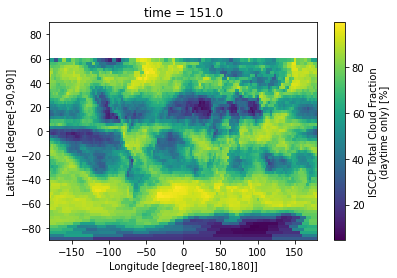

In [21]:
t150.plot()

In [27]:
attrs = {"units": "hours since 2000-01-01"}

ds = xr.Dataset({"time": ("time", [0, 1, 2, 3], attrs)})

out = xr.decode_cf(ds)

In [24]:
out

<xarray.Dataset>
Dimensions:  (time: 4)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T03:00:00
Data variables:
    *empty*